# <center> Butter-E Dataset Notebooks: Energy-Loss Plots </center>
---

This notebook contains the code to produce the energy-loss figures of the paper.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import plotly.express as px

import pyarrow.parquet as pq
import scipy.interpolate

from pprint import pprint
from pandas.api.types import is_numeric_dtype
import matplotlib

from common import *

/home/ctripp/gcomp/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
experiments = pd.read_parquet("data_artifacts/experiments.pq")
experiments.sort_values(["experiment_id", "has_gpu"], inplace=True)

In [3]:
np.set_printoptions(
    edgeitems=3,
    infstr="inf",
    linewidth=75,
    nanstr="nan",
    precision=8,
    suppress=False,
    threshold=10000,
    formatter=None,
)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)


plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 8

In [4]:
epoch_column = "epoch"
per_epoch_metrics = [
    "test_loss_best_quantile_0",
    "test_loss_best_quantile_25",
    "test_loss_best_quantile_50",
    "test_loss_best_quantile_75",
    "test_loss_best_quantile_100",
]
per_epoch_columns = [epoch_column] + per_epoch_metrics
# data = data[["experiment_id", "shape", "dataset", "size", "depth", "energy", "std_energy",] + per_epoch_columns]

epoch_data = experiments.explode(per_epoch_columns)
# data.set_index(["has_gpu", "experiment_id", "epoch"], inplace=True, drop=False)
# data.sort_index(inplace=True)

epoch_data["epoch"] = epoch_data["epoch"].astype(np.int32)
for column in per_epoch_metrics:
    epoch_data[column] = epoch_data[column].astype(np.float32)


epoch_data["energy_at_epoch"] = (
    epoch_data["non_overhead_energy"] * (epoch_data["epoch"] / 3000.0)
).astype(np.float64)

epoch_data["log_energy_at_epoch"] = np.log(epoch_data["energy_at_epoch"]).astype(
    np.float64
)
for column in per_epoch_metrics:
    epoch_data[f"log_{column}"] = np.log(1e-18 + epoch_data[column]).astype(np.float64)


epoch_data["log_epoch"] = np.log(epoch_data["epoch"]).astype(np.float64)
epoch_data["log_data_parameters"] = np.log(
    epoch_data["epoch"]
    * epoch_data["batch_size"]
    * np.ceil((epoch_data["n_observations"] * 0.8) / epoch_data["batch_size"])
    * epoch_data["num_free_parameters"]
).astype(np.float64)


epoch_data["log_runtime_at_epoch"] = np.log(
    epoch_data["non_overhead_runtime"] * epoch_data["epoch"] / 3000
)
epoch_data.sort_values(
    by=["has_gpu", "dataset", "shape", "depth", "size", "experiment_id", "epoch"],
    inplace=True,
)
print(epoch_data.columns.tolist())

epoch_data["flops"] = epoch_data["flops_per_epoch"] * epoch_data["epoch"]
epoch_data["log_flops"] = np.log(epoch_data["flops"])

epoch_data.to_parquet("./data_artifacts/epoch_data.pq")

['experiment_id', 'depth', 'size', 'run_time', 'energy', 'power', 'std_energy', 'std_power', 'energy_overhead', 'non_overhead_energy', 'runtime_overhead', 'non_overhead_runtime', 'has_gpu', 'median_idle_power_for_type', 'idle_power', 'node', 'dataset', 'shape', 'type', 'n_observations', 'n_features', 'n_classes', 'Endpoint', 'Imbalance', 'Task', 'Metadata', 'num_free_parameters', 'widths', 'num_runs', 'task', 'batch_size', 'learning_rate', 'test_loss_best_quantile_0', 'epoch', 'test_loss_best_quantile_25', 'test_loss_best_quantile_50', 'test_loss_best_quantile_75', 'test_loss_best_quantile_100', 'num_epochs', 'full_widths', 'num_nodes', 'log_size', 'log_parameters', 'num_training_batches_per_epoch', 'num_test_batches_per_epoch', 'num_batches_per_epoch', 'energy_per_training_batch', 'energy_per_training_datum', 'log10_energy_per_training_datum', 'seconds_per_training_batch', 'log10_energy_per_training_batch', 'traning_data_per_epoch', 'energy_per_epoch', 'energy_per_data_per_epochs_per_

In [5]:
def do_interpolation(args, resolution=200, eta=1e-9):
    (
        min_response,
        max_response,
        experiment_df,
        response_result_column_map,
        input_column,
    ) = args
    example = experiment_df.iloc[0]

    step = max(eta, (max_response - min_response)) / resolution
    interp_points = np.arange(
        min_response,
        max_response,
        step,
    )
    interp_index = np.fromiter(range(len(interp_points)), dtype=np.int32)

    interp_selection = np.logical_and(
        interp_points >= experiment_df["log_test_loss_best_quantile_50"].min(),
        interp_points <= experiment_df["log_test_loss_best_quantile_50"].max(),
    )
    interp_range = interp_points[interp_selection]
    interp_index = interp_index[interp_selection]

    interpolated_loss_data = {
        key: [example[key]] * len(interp_range)
        for key in experiment_df.columns
        # ["experiment_id", "shape", "depth", "dataset", "size", "log_size"]
    }

    interpolated_loss_data["loss_index"] = np.array(interp_index, dtype=np.uint8)
    interpolated_loss_data["log_loss"] = np.array(interp_range, dtype=np.float32)

    for response_column, result_column in response_result_column_map.items():
        for quantile in [0, 25, 50, 75, 100]:
            key = f"{input_column}{quantile}"

            grouped_values = experiment_df[[key, response_column]].groupby(key).median()
            grouped_values.reset_index(inplace=True)

            response_values = grouped_values[response_column]
            input_values = grouped_values[key]

            if len(grouped_values.index) <= 0:
                continue

            if len(grouped_values.index) < 2:
                values = np.full(interp_range.shape, response_values.iloc[0])
            else:
                interpolator = scipy.interpolate.interp1d(
                    input_values,
                    response_values,
                    kind="linear",
                    axis=-1,
                    copy=True,
                    bounds_error=False,
                    fill_value=(response_values.iloc[0], response_values.iloc[-1]),
                    assume_sorted=True,
                )
                values = np.array(interpolator(interp_range), dtype=np.float32)

            interpolated_loss_data[f"{result_column}_quantile_{quantile}"] = values

    return pd.DataFrame(interpolated_loss_data)

In [6]:
def batch_processor(source_args):
    dfs = []
    for args in source_args:
        dfs.append(do_interpolation(args))
    return pd.concat(dfs, axis=0, ignore_index=True)


def make_interpolated_dataset(df, filename, response_result_column_map, input_column):
    num_tasks = df.groupby(["has_gpu", "dataset", "experiment_id"]).ngroups
    print(f"num_tasks {num_tasks}")

    def work_generator():
        print("begin")
        pct = 0.0
        n = 0
        m = 0
        source_args = []
        for (has_gpu, dataset), parent_group in df.groupby(["has_gpu", "dataset"]):
            min_response = parent_group[f"{input_column}50"].min()
            max_response = parent_group[f"{input_column}50"].max()

            for exeperiment_id, experiment_group in parent_group.groupby(
                "experiment_id"
            ):
                source_args.append(
                    (
                        min_response,
                        max_response,
                        experiment_group,
                        response_result_column_map,
                        input_column,
                    )
                )
                if len(source_args) >= 32:
                    n += 1
                    m += len(source_args)
                    this_pct = 100.0 * m / num_tasks
                    if this_pct - pct >= 1.0:
                        print(f"Generated {m} / {num_tasks} : {100.0*m/num_tasks}%")
                        pct = this_pct
                    yield source_args
                    source_args = []
        yield source_args

    import multiprocess
    from contextlib import closing

    with closing(multiprocess.Pool(maxtasksperchild=100)) as pool:
        print("pool active")
        # dfs = list(pool.imap_unordered(func, np.array_split(df2["experiment_id"].unique(), 4)))
        dfs = list(pool.imap_unordered(batch_processor, work_generator()))

    print("closed pool, concatenating")

    interpolated_df = pd.concat(dfs, axis=0, ignore_index=True)
    return interpolated_df

In [7]:
compute_interpolation = False  # set to True if you want to recompute the interpolation
interpolated_loss_path = "data_artifacts/interpolated_loss.pq"
if not compute_interpolation and os.path.exists(interpolated_loss_path):
    print("file found, loading...")
    interpolated_loss = pd.read_parquet(interpolated_loss_path)
else:
    interpolation_data = epoch_data[
        [
            "has_gpu",
            "dataset",
            "experiment_id",
            "test_loss_best_quantile_0",
            "epoch",
            "test_loss_best_quantile_25",
            "test_loss_best_quantile_50",
            "test_loss_best_quantile_75",
            "test_loss_best_quantile_100",
            "log_energy_at_epoch",
            "log_test_loss_best_quantile_0",
            "log_test_loss_best_quantile_25",
            "log_test_loss_best_quantile_50",
            "log_test_loss_best_quantile_75",
            "log_test_loss_best_quantile_100",
            "log_epoch",
            "log_data_parameters",
            "log_runtime_at_epoch",
            "log_flops",
        ]
    ]
    interpolated_loss = make_interpolated_dataset(
        interpolation_data,
        "interpolated_loss.pq",
        {
            "log_energy_at_epoch": "log_energy",
            "log_runtime_at_epoch": "log_runtime",
            "log_epoch": "log_epoch",
            "log_data_parameters": "log_data_parameters",
            "log_flops": "log_flops",
        },
        "log_test_loss_best_quantile_",
    )
    print(f"merging and formatting...")

    interpolated_loss = interpolated_loss.merge(
        experiments[
            [
                c
                for c in experiments.columns
                if c in ["experiment_id", "has_gpu"]
                or c not in interpolated_loss.columns
            ]
        ],
        on=["experiment_id", "has_gpu"],
        how="inner",
    )
    for col in (
        "epoch",
        "log_epoch",
        "flops",
        "log_flops",
    ):
        if col in interpolated_loss.columns:
            del interpolated_loss[col]

    interpolated_loss["experiment_id"] = interpolated_loss["experiment_id"].astype(
        np.int64
    )
    interpolated_loss["depth"] = interpolated_loss["depth"].astype(np.int16)

    interpolated_loss["has_gpu"] = interpolated_loss["has_gpu"].astype(bool)

    for col in (
        "epoch",
        "energy",
        "data_parameters",
        "flops",
    ):
        interpolated_loss[col] = np.exp(interpolated_loss[f"log_{col}_quantile_50"])

    print("saving")
    interpolated_loss.to_parquet(
        interpolated_loss_path, index=False, compression="zstd", compression_level=8
    )
    print("saved")

print("sorting")
interpolated_loss.sort_values(
    ["has_gpu", "dataset", "depth", "shape", "size", "experiment_id", "loss_index"],
    inplace=True,
)
print("done.")

file found, loading...
sorting
done.


In [8]:
print(np.log2(sorted(interpolated_loss["size"].unique())))
print(sorted(interpolated_loss["depth"].unique()))
print(sorted(interpolated_loss["dataset"].unique()))
print(sorted(interpolated_loss["shape"].unique()))

interpolated_loss.head(3)

[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22.
 23. 24.]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]
['201_pol', '294_satellite_image', '529_pollen', '537_houses', 'adult', 'banana', 'connect_4', 'mnist', 'nursery', 'sleep', 'splice', 'wine_quality_white']
['exponential', 'rectangle', 'rectangle_residual', 'trapezoid', 'wide_first_16x', 'wide_first_2x', 'wide_first_4x', 'wide_first_8x']


,has_gpu,dataset,experiment_id,test_loss_best_quantile_0,test_loss_best_quantile_25,test_loss_best_quantile_50,test_loss_best_quantile_75,test_loss_best_quantile_100,log_energy_at_epoch,log_test_loss_best_quantile_0,log_test_loss_best_quantile_25,log_test_loss_best_quantile_50,log_test_loss_best_quantile_75,log_test_loss_best_quantile_100,log_data_parameters,log_runtime_at_epoch,loss_index,log_loss,log_energy_quantile_0,log_energy_quantile_25,log_energy_quantile_50,log_energy_quantile_75,log_energy_quantile_100,log_runtime_quantile_0,log_runtime_quantile_25,log_runtime_quantile_50,log_runtime_quantile_75,log_runtime_quantile_100,log_epoch_quantile_0,log_epoch_quantile_25,log_epoch_quantile_50,log_epoch_quantile_75,log_epoch_quantile_100,log_data_parameters_quantile_0,log_data_parameters_quantile_25,log_data_parameters_quantile_50,log_data_parameters_quantile_75,log_data_parameters_quantile_100,log_flops_quantile_0,log_flops_quantile_25,log_flops_quantile_50,log_flops_quantile_75,log_flops_quantile_100,depth,size,run_time,energy,power,std_energy,std_power,energy_overhead,non_overhead_energy,runtime_overhead,non_overhead_runtime,median_idle_power_for_type,idle_power,node,shape,type,n_observations,n_features,n_classes,Endpoint,Imbalance,Task,Metadata,num_free_parameters,widths,num_runs,task,batch_size,learning_rate,num_epochs,full_widths,num_nodes,log_size,log_parameters,num_training_batches_per_epoch,num_test_batches_per_epoch,num_batches_per_epoch,energy_per_training_batch,energy_per_training_datum,log10_energy_per_training_datum,seconds_per_training_batch,log10_energy_per_training_batch,traning_data_per_epoch,energy_per_epoch,energy_per_data_per_epochs_per_size,fwd_operations,max_width,bwd_layer_operations,bwd_reduce_operations,bwd_operations,flops_per_epoch,flops_per_training_datum,zero,zeros,per_layer_interlayer_working_set_distributed,per_layer_interlayer_working_set_cache_level,per_layer_interlayer_working_set_cached_size,per_layer_interlayer_working_set_occupied_size,per_layer_interlayer_working_set_singular_size,per_layer_interlayer_working_set_singular_occupied_size,per_layer_interlayer_working_set_effective_size,per_layer_interlayer_working_set_cache_level_1_size,per_layer_interlayer_working_set_cache_level_1_cumulative_size,per_layer_interlayer_working_set_cache_level_1_count,per_layer_interlayer_working_set_cache_level_1_cumulative_count,per_layer_interlayer_working_set_cache_level_2_size,per_layer_interlayer_working_set_cache_level_2_cumulative_size,per_layer_interlayer_working_set_cache_level_2_count,per_layer_interlayer_working_set_cache_level_2_cumulative_count,per_layer_interlayer_working_set_cache_level_3_size,per_layer_interlayer_working_set_cache_level_3_cumulative_size,per_layer_interlayer_working_set_cache_level_3_count,per_layer_interlayer_working_set_cache_level_3_cumulative_count,per_layer_interlayer_working_set_cache_level_4_size,per_layer_interlayer_working_set_cache_level_4_cumulative_size,per_layer_interlayer_working_set_cache_level_4_count,per_layer_interlayer_working_set_cache_level_4_cumulative_count,per_layer_interlayer_working_set_max_cache_level,per_layer_interlayer_working_set_max_cached_size,per_layer_interlayer_working_set_max_occupied_size,per_layer_interlayer_working_set_max_singular_size,per_layer_interlayer_working_set_max_singular_occupied_size,per_layer_interlayer_working_set_max_effective_size,per_layer_interlayer_working_set_max_distributed,fwd_pass_working_set_replicated,fwd_pass_working_set_cache_level,fwd_pass_working_set_cached_size,fwd_pass_working_set_occupied_size,fwd_pass_working_set_singular_size,fwd_pass_working_set_singular_occupied_size,fwd_pass_working_set_effective_size,bwd_pass_working_set_distributed,bwd_pass_working_set_replicated,bwd_pass_working_set_cache_level,bwd_pass_working_set_cached_size,bwd_pass_working_set_occupied_size,bwd_pass_working_set_singular_size,bwd_pass_working_set_singular_occupied_size,bwd_pass_working_set_effective_size,bytes_per_datum,dataset_

In [9]:
pprint(list(interpolated_loss.columns))

['has_gpu',
 'dataset',
 'experiment_id',
 'test_loss_best_quantile_0',
 'test_loss_best_quantile_25',
 'test_loss_best_quantile_50',
 'test_loss_best_quantile_75',
 'test_loss_best_quantile_100',
 'log_energy_at_epoch',
 'log_test_loss_best_quantile_0',
 'log_test_loss_best_quantile_25',
 'log_test_loss_best_quantile_50',
 'log_test_loss_best_quantile_75',
 'log_test_loss_best_quantile_100',
 'log_data_parameters',
 'log_runtime_at_epoch',
 'loss_index',
 'log_loss',
 'log_energy_quantile_0',
 'log_energy_quantile_25',
 'log_energy_quantile_50',
 'log_energy_quantile_75',
 'log_energy_quantile_100',
 'log_runtime_quantile_0',
 'log_runtime_quantile_25',
 'log_runtime_quantile_50',
 'log_runtime_quantile_75',
 'log_runtime_quantile_100',
 'log_epoch_quantile_0',
 'log_epoch_quantile_25',
 'log_epoch_quantile_50',
 'log_epoch_quantile_75',
 'log_epoch_quantile_100',
 'log_data_parameters_quantile_0',
 'log_data_parameters_quantile_25',
 'log_data_parameters_quantile_50',
 'log_data_para

In [10]:
pprint(epoch_data["log_epoch"].sample(10))

27125    6.124683
12614    6.033086
23026    7.091742
7038     3.178054
13176    7.229839
31560    4.143135
8181     5.252273
24367    4.007333
10358    3.401197
13714    7.183871
Name: log_epoch, dtype: float64


In [11]:
pprint(np.exp(interpolated_loss["log_data_parameters"].sample(20)))

877286     2.141184e+07
247568     2.120294e+07
1956147    2.801457e+09
681165     3.650862e+10
928530     5.561224e+09
143285     4.428749e+07
343618     2.679373e+07
2003571    8.387328e+07
333072     5.454925e+07
889857     1.374094e+09
73366      1.987686e+08
574434     4.570962e+09
1643971    1.141321e+09
1588127    2.851474e+08
1624821    4.190976e+06
797571     2.875904e+06
363502     2.791820e+10
1117646    4.964403e+07
57620      7.861588e+08
2024001    5.652480e+06
Name: log_data_parameters, dtype: float64


# Plots

In [12]:
plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 8

In [13]:
print(interpolated_loss["dataset"].unique())

['201_pol' '294_satellite_image' '529_pollen' '537_houses' 'adult'
 'banana' 'connect_4' 'mnist' 'nursery' 'sleep' 'splice'
 'wine_quality_white']


(True, 'connect_4', 'trapezoid', 4)
(True, 'connect_4', 'trapezoid', 4)
(False, 'connect_4', 'trapezoid', 4)
(True, '201_pol', 'rectangle', 2)
(True, '201_pol', 'rectangle', 2)
(False, '201_pol', 'rectangle', 2)
(True, 'mnist', 'rectangle', 6)
(True, 'mnist', 'rectangle', 6)
(False, 'mnist', 'rectangle', 6)
(True, 'sleep', 'exponential', 8)
(True, 'sleep', 'exponential', 8)
(False, 'sleep', 'exponential', 8)


/tmp/ipykernel_56655/1270503834.py:235: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


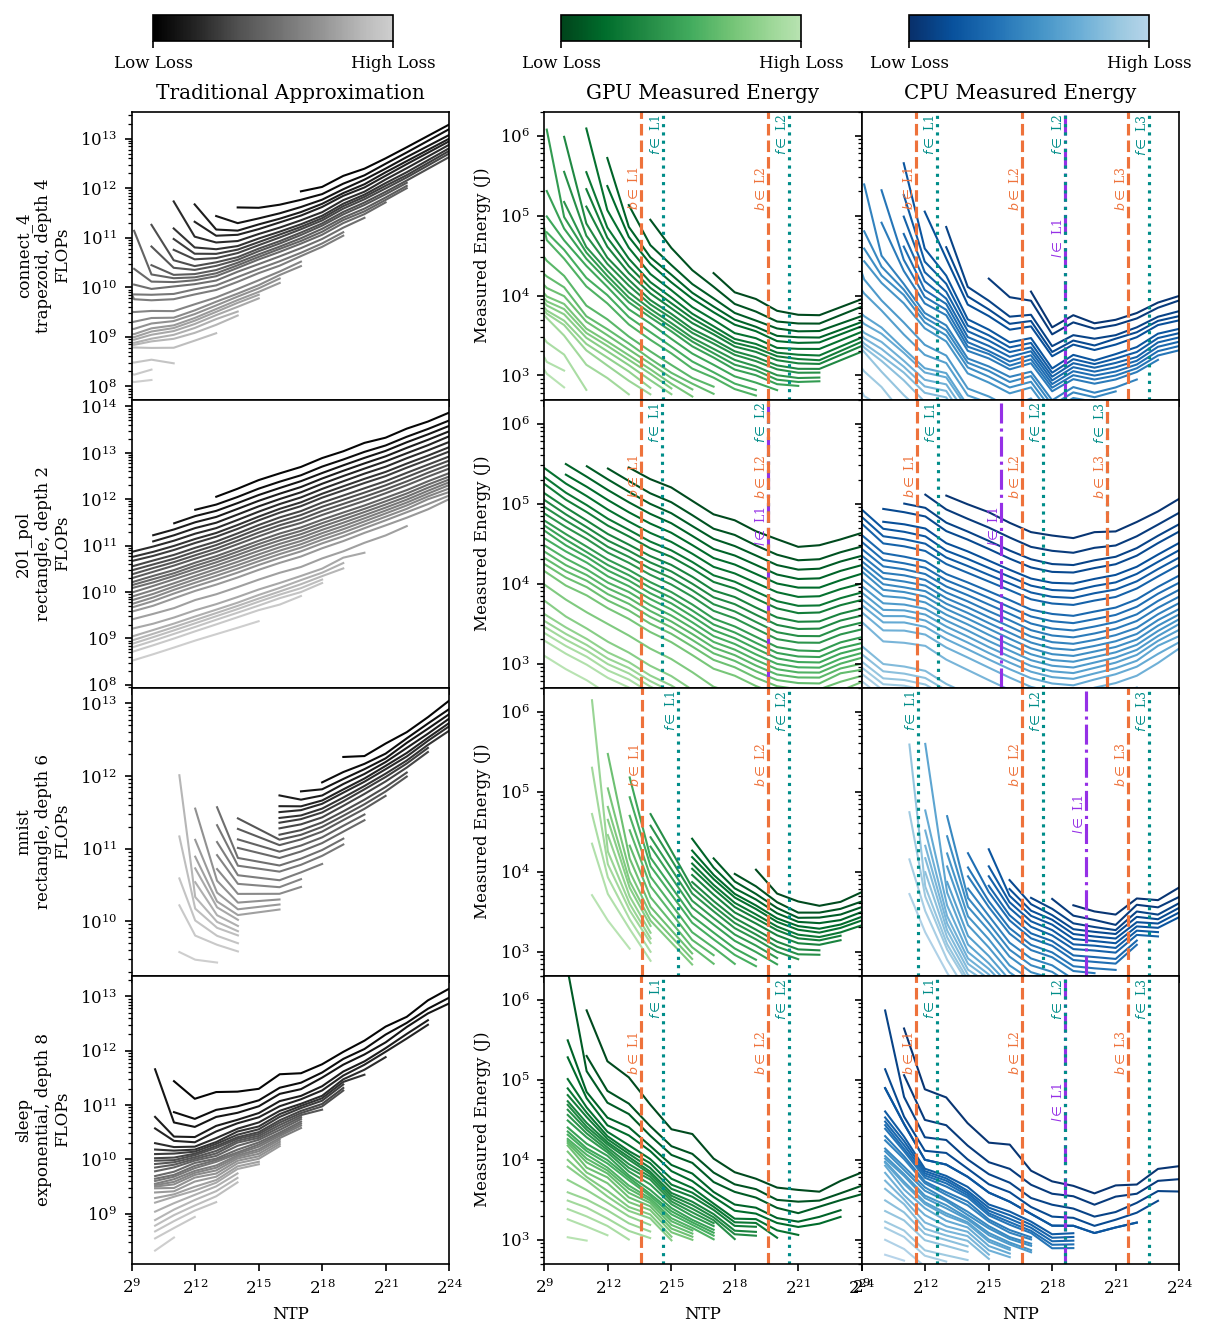

In [14]:
## High level config
examples = [
    ("connect_4", "trapezoid", 4),
    ("201_pol", "rectangle", 2),
    ("mnist", "rectangle", 6),
    ("sleep", "exponential", 8),
]

data = interpolated_loss.set_index(
    ["has_gpu", "dataset", "shape", "depth", "loss_index", "log_size"]
)
data.sort_index(inplace=True)


# pprint(data.loc[(True, '201_pol', 'exponential', 3)])


# fig = plt.figure(figsize=(8, (8 / 4) * 3), dpi=150)
fig = plt.figure(figsize=(8, 0.5 + len(examples) * 2), dpi=150)
gs = fig.add_gridspec(len(examples), 4, hspace=0, wspace=0, width_ratios=[1, 0.3, 1, 1])
# axs = gs.subplots(sharex="col", sharey="row")
axs = gs.subplots(sharex="col", sharey=None)

for ax in axs[:, 1].tolist():
    # Remove column 1 to create a spacer
    ax.set_visible(False)


def plot_cache_boundary(
    ax,
    df,
    x_col,
    working_set,
    level,
    color,
    linestyle,
    working_set_symbol,
    text_offset=0,
):
    cl = f"{working_set}_cache_level"

    df = df.sort_values(x_col)
    try:
        lo = df.loc[df[cl] <= level, x_col].iloc[-1]
        hi = df.loc[df[cl] > level, x_col].iloc[0]
    except:
        return

    pos = lo + (hi - lo) / 2

    ax.axvline(x=pos, color=color, linestyle=linestyle, label="Cache Size")
    ax.text(
        pos,
        0.99 - text_offset,
        f"${working_set_symbol} \in$ L{level}",
        color=color,
        ha="right",
        va="top",
        size=6,
        rotation=90,
        transform=ax.get_xaxis_transform(),
    )


def plot_isolines(
    ax,
    example,
    loss_colors,
    x_col,
    y_col,
    column_type,
):
    pprint(example)
    df = data.loc[example]
    num_levels = 30
    colors = loss_colors(np.linspace(0, 1, num_levels))
    # pprint(df.index)

    levels = df.index.get_level_values(0).to_list()
    levels = levels[:: int(np.ceil(len(levels) / num_levels))]
    for level, color in zip(levels, colors):
        gdf = df.loc[(level,)]
        if len(gdf) < 1:
            continue
        if level == min(
            levels
        ):  # Exclude the lowest loss level since it is a straight line
            continue

        ax.plot(
            gdf[x_col],
            # df[y_variable],
            gdf[y_col],
            color=color,
            # alpha=0.02,
            lw=1,
        )

    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=2)

    if column_type == "trad":
        pass
    else:
        spacing = 0.18

        plot_cache_boundary(
            ax,
            df,
            x_col,
            "per_layer_interlayer_working_set_max",
            1,
            working_set_colors[0],
            "-.",
            "l",
            spacing * 2,
        )
        plot_cache_boundary(
            ax, df, x_col, "fwd_pass_working_set", 1, working_set_colors[1], ":", "f"
        )
        plot_cache_boundary(
            ax, df, x_col, "fwd_pass_working_set", 2, working_set_colors[1], ":", "f"
        )
        plot_cache_boundary(
            ax,
            df,
            x_col,
            "bwd_pass_working_set",
            1,
            working_set_colors[2],
            "--",
            "b",
            spacing,
        )
        plot_cache_boundary(
            ax,
            df,
            x_col,
            "bwd_pass_working_set",
            2,
            working_set_colors[2],
            "--",
            "b",
            spacing,
        )

        if column_type == "cpu":
            plot_cache_boundary(
                ax,
                df,
                x_col,
                "fwd_pass_working_set",
                3,
                working_set_colors[1],
                ":",
                "f",
            )
            plot_cache_boundary(
                ax,
                df,
                x_col,
                "bwd_pass_working_set",
                3,
                working_set_colors[2],
                "--",
                "b",
                spacing,
            )


trad_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "trad", plt.cm.Greys_r(np.linspace(0.0, 0.7, 256))
)
gpu_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "gpu", plt.cm.Greens_r(np.linspace(0.0, 0.7, 256))
)
cpu_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "cpu", plt.cm.Blues_r(np.linspace(0.0, 0.7, 256))
)

for i, example in enumerate(examples):
    axs[i][0].set_ylabel(f"{example[0]}\n{example[1]}, depth {example[2]}\nFLOPs")

    axs[i][2].set_ylabel("Measured Energy (J)")
    axs[i][3].tick_params(labelleft=False)
    axs[i][2].set_ylim(0.5e3, 2e6)
    axs[i][3].set_ylim(0.5e3, 2e6)

    plot_isolines(
        axs[i][0], (True,) + example, trad_cmap, "num_free_parameters", "flops", "trad"
    )
    plot_isolines(
        axs[i][2], (True,) + example, gpu_cmap, "num_free_parameters", "energy", "gpu"
    )
    plot_isolines(
        axs[i][3], (False,) + example, cpu_cmap, "num_free_parameters", "energy", "cpu"
    )

axs[0][0].set_title("Traditional Approximation")
axs[0][2].set_title("GPU Measured Energy")
axs[0][3].set_title("CPU Measured Energy")

for j in [0, 2, 3]:
    axs[-1][j].set_xlabel("NTP")
    axs[-1][j].set_xlim(2**9, 2**24)

### Colorbar
cb_ax = fig.add_axes([0.13, 1.02, 0.2, 0.02])
cb = matplotlib.colorbar.ColorbarBase(
    cb_ax,
    orientation="horizontal",
    cmap=trad_cmap,
    ticks=[0, 1],
)
cb.set_ticklabels(["Low Loss", "High Loss"])

cb_ax = fig.add_axes([0.13 + 0.34, 1.02, 0.2, 0.02])
cb = matplotlib.colorbar.ColorbarBase(
    cb_ax,
    orientation="horizontal",
    cmap=gpu_cmap,
    ticks=[0, 1],
)
cb.set_ticklabels(["Low Loss", "High Loss"])

cb_ax = fig.add_axes([0.13 + 0.34 + 0.29, 1.02, 0.2, 0.02])
cb = matplotlib.colorbar.ColorbarBase(
    cb_ax,
    orientation="horizontal",
    cmap=cpu_cmap,
    ticks=[0, 1],
)
cb.set_ticklabels(["Low Loss", "High Loss"])

plt.tight_layout()
plt.savefig("figures/7_sample_isolines.svg", dpi=600, bbox_inches="tight")
plt.savefig("figures/7_sample_isolines.png", dpi=600, bbox_inches="tight")
plt.show()

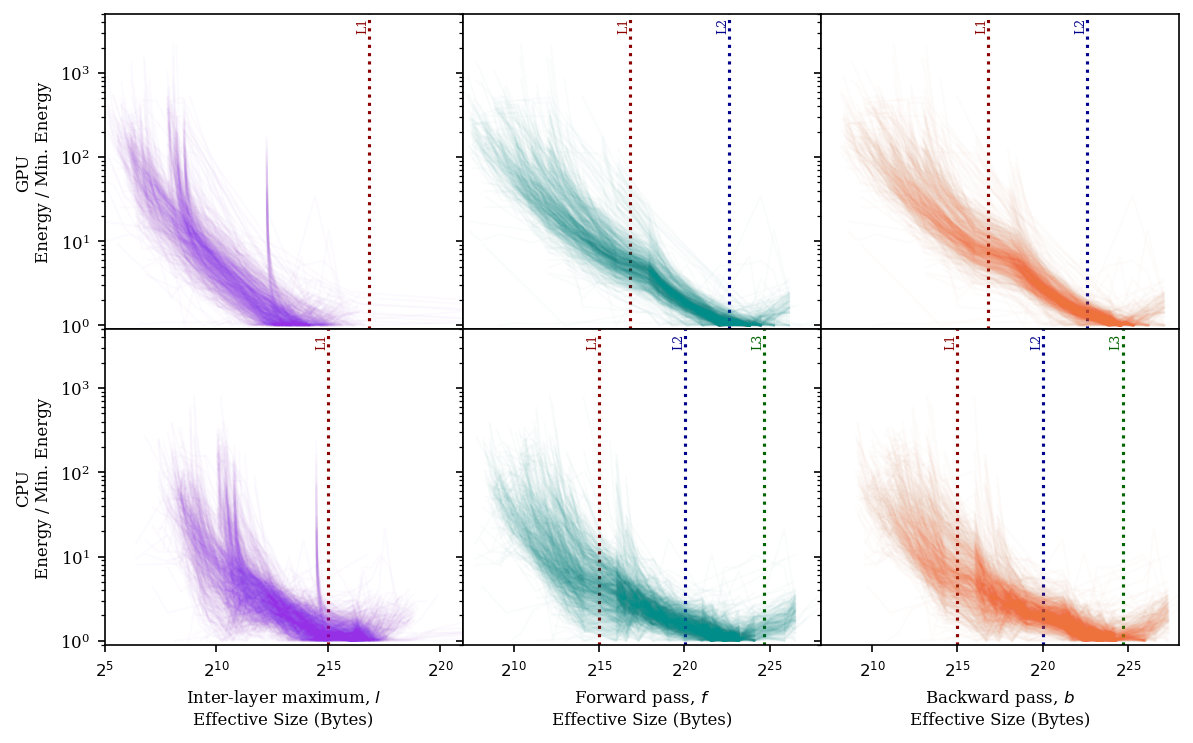

In [15]:
#### The Plot

# fig = plt.figure(figsize=(8, (8 / 4) * 3), dpi=150)
fig = plt.figure(figsize=(8, 5), dpi=150)
gs = fig.add_gridspec(
    2,
    3,
    hspace=0,
    wspace=0,
    width_ratios=[
        1,
        1,
        1,
    ],
)
axs = gs.subplots(sharex="col", sharey="row")


## High level config

working_set_for_x_axis = [
    "per_layer_interlayer_working_set_max",
    "fwd_pass_working_set",
    "bwd_pass_working_set",
]

actual_cache_sizes = {
    "cpu": [
        cpu_level_1_bytes_per_core,
        cpu_level_1_bytes_per_core + cpu_level_2_bytes_per_core,
        cpu_level_1_bytes_per_core
        + cpu_level_2_bytes_per_core
        + cpu_level_3_bytes_per_socket,
    ],
    "gpu": [
        gpu_level_1_bytes_per_sm,
        gpu_level_1_bytes_per_sm + gpu_level_2_bytes_per_gpu,
    ],
}

caches_to_plot_as_vertical_lines = [
    [actual_cache_sizes],
    [actual_cache_sizes],
    [actual_cache_sizes],
]


cache_levels_to_plot_as_vertical_lines = [
    {"cpu": [1], "gpu": [1]},
    {"cpu": [1, 2, 3], "gpu": [1, 2]},
    {"cpu": [1, 2, 3], "gpu": [1, 2]},
]


## Get main data subset for this plot


# identify selected isoloss lines --------------------------------
loss_index_key = "loss_index"
group_keys = ["has_gpu", "dataset", "depth", "shape", loss_index_key]
drop_keys = ["log_size"]
index_keys = group_keys + drop_keys
subset = interpolated_loss.set_index(index_keys)
subset.sort_index(inplace=True)
subset["log_size_"] = subset.index.get_level_values(drop_keys[0])
subset["loss_index_"] = subset.index.get_level_values(loss_index_key)
groups = subset.groupby(group_keys)


# reject noisy isoloss lines (happens with the very lowest loss levels that were only sometimes attained)
dset_mask = groups["epoch"].min() == groups["epoch"].tail(1).droplevel(drop_keys)
dset_mask &= groups["epoch"].max() == groups["epoch"].head(1).droplevel(drop_keys)

dset_mask &= (groups["log_size_"].min() <= 14) & (groups["log_size_"].max() >= 21)

subset = subset.loc[dset_mask]
subset = subset.loc[
    subset["loss_index_"]
    == subset.groupby(group_keys[:-1])["loss_index_"].transform("max")
]


def plot_common_isolines(
    data,
    ax,
    y_variable,
    x_variable,
    color,
):
    for dataset, df in data.groupby(["has_gpu", "dataset", "depth", "shape"]):
        if len(df) < 2:
            continue

        # offset relative to cache level:
        df = df.sort_values(x_variable)

        ax.plot(
            df[x_variable],
            # df[y_variable],
            df[y_variable] / df[y_variable].min(),
            color=color,
            alpha=0.02,
            lw=1,
        )


def plot_actual_cache_level_lines(ax, col, hardware="cpu", color="red", linestyle="--"):
    for cache_level in cache_levels_to_plot_as_vertical_lines[col][hardware]:
        cache_size = (actual_cache_sizes[hardware][cache_level - 1])
        color = cache_colors[cache_level - 1]
        ax.axvline(
            x=cache_size, color=color, linestyle=linestyle, lw=1.5, label="Actual Cache Size"
        )
        ax.text(
            cache_size,
            0.99,
            f"L{cache_level}",
            color=color,
            ha="right",
            va="top",
            size=6,
            rotation=90,
            transform=ax.get_xaxis_transform(),
        )


def plot_aggregate_figure(ax, df, col, device, rowlabel):
    working_set = working_set_for_x_axis[col]
    plot_actual_cache_level_lines(ax, col, device, "black", ":")
    plot_common_isolines(
        df,
        ax=ax,
        y_variable="energy",
        x_variable=f"{working_set}_occupied_size",
        color=working_set_colors[col],
    )

    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=2)
    if col == 0:
        # ax.set_ylabel("Energy Used / Min. To Reach Loss")
        ax.set_ylabel(f"{rowlabel}\nEnergy / Min. Energy")


def make_combined_dataset_column(col):
    plot_aggregate_figure(axs[0][col], subset.query("has_gpu==1"), col, "gpu", "GPU")
    plot_aggregate_figure(axs[1][col], subset.query("has_gpu==0"), col, "cpu", "CPU")
    axs[1][col].set_xlabel(f"{working_set_labels[col]}\nEffective Size (Bytes)")

    for col_axs in axs:
        pows = [10, 15, 20, 25]
        col_axs[col].set_xticks(np.power(2, pows))
        col_axs[col].set_xticklabels(["$2^{" + str(n) + "}$" for n in pows])
        col_axs[col].set_ylim(0.9, 5e3)
        col_axs[col].set_xlim(2**7, 2**28)


for col in range(len(working_set_for_x_axis)):
    make_combined_dataset_column(col)

for col_axs in axs:
    pows = [
        5,
        10,
        15,
        20,
    ]
    col_axs[0].set_xticks(np.power(2, pows))
    col_axs[0].set_xticklabels(["$2^{" + str(n) + "}$" for n in pows])
    col_axs[0].set_xlim(2**5, 2**21)

plt.tight_layout()
plt.savefig("figures/7_aggregate_isolines.png", dpi=300, bbox_inches="tight")
plt.show()

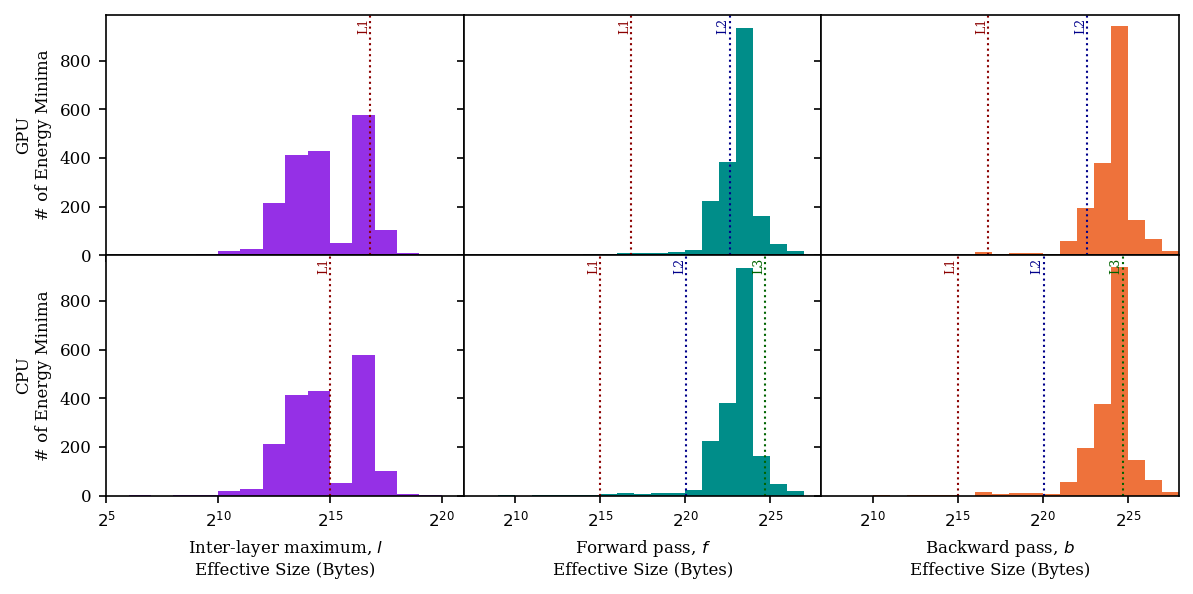

In [16]:
#### The Plot

fig = plt.figure(figsize=(8, 4), dpi=150)
gs = fig.add_gridspec(
    2,
    3,
    hspace=0,
    wspace=0,
    width_ratios=[
        1,
        1,
        1,
    ],
)
axs = gs.subplots(sharex="col", sharey="row")


mins = subset.loc[
    subset["energy"] == subset.groupby(group_keys)["energy"].transform("min")
]


def plot_actual_cache_level_lines(ax, col, hardware="cpu", color="red", linestyle=":"):
    for cache_level in cache_levels_to_plot_as_vertical_lines[col][hardware]:
        cache_size = np.log2(actual_cache_sizes[hardware][cache_level - 1])
        color = cache_colors[cache_level - 1]
        ax.axvline(
            x=cache_size, color=color, linestyle=linestyle, lw=1.0, label="Actual Cache Size"
        )
        ax.text(
            cache_size,
            0.99,
            f"L{cache_level}",
            color=color,
            ha="right",
            va="top",
            size=6,
            rotation=90,
            transform=ax.get_xaxis_transform(),
        )


def plot_aggregate_figure(ax, df, col, device, rowlabel):
    working_set = working_set_for_x_axis[col]

    ax.hist(
        np.log2(mins[f"{working_set}_occupied_size"]),
        bins=list(range(5, 36)),
        color=working_set_colors[col],
    )
    plot_actual_cache_level_lines(ax, col, device, ":")
    # plot_common_isolines(
    #     df,
    #     ax=ax,
    #     y_variable="energy",
    #     x_variable=f"{working_set}_occupied_size",
    # )

    # ax.set_yscale("log", base=10)
    # ax.set_xscale("log", base=2)
    if col == 0:
        ax.set_ylabel(f"{rowlabel}\n# of Energy Minima")


def make_combined_dataset_column(col):
    plot_aggregate_figure(axs[0][col], subset.query("has_gpu==1"), col, "gpu", "GPU")
    plot_aggregate_figure(axs[1][col], subset.query("has_gpu==0"), col, "cpu", "CPU")
    axs[1][col].set_xlabel(f"{working_set_labels[col]}\nEffective Size (Bytes)")
    # axs[0][col].set_ylim(.5, 5e3)
    for col_axs in axs:
        pows = [10, 15, 20, 25]
        col_axs[col].set_xticks(pows)
        col_axs[col].set_xticklabels(["$2^{" + str(n) + "}$" for n in pows])
        col_axs[col].set_xlim(7, 28)


for col in range(len(working_set_for_x_axis)):
    make_combined_dataset_column(col)

for col_axs in axs:
    pows = [5, 10, 15, 20]
    col_axs[0].set_xticks(pows)
    col_axs[0].set_xticklabels(["$2^{" + str(n) + "}$" for n in pows])
    col_axs[0].set_xlim(5, 21)

plt.tight_layout()
plt.savefig("figures/7_minimum_histograms.svg", dpi=600, bbox_inches="tight")
plt.savefig("figures/7_minimum_histograms.png", dpi=600, bbox_inches="tight")
plt.show()